In [20]:
%load_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html

from dataprep import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import pickle
import random
import scanpy as sc
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed = 101
random.seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)


custom = {"axes.edgecolor": "grey"}
sns.set_style("whitegrid")
plt.rcParams['grid.alpha'] = 0.4
sns.set_palette("colorblind")
colorblind_palette = sns.color_palette("colorblind")
# Like colorblind_palette[4] for control, colorblind_palette[0] for test

## Loading RF Models & Datasets

Paths to pericellular/other patterns RF models

In [20]:
path1 = "/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pericellular.pkl"
with open(path1, 'rb') as p:
    rf_pericellular_splitID_balanced = pickle.load(p)

# The plots from the ppt are from this unbalanced model, didn't have the time to make a balanced version yet.
path2 = "/media/gambino/students_workdir/nynke/blurry/temp_objects/incl_random/rf_pericellular.pkl"
with open(path2, 'rb') as p:
    rf_pericellular_inclRandom_splitID_unbalanced = pickle.load(p)

path3 = "/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pericellular_balanced_mixedIDs.pkl"
with open(path3, 'rb') as p:
    rf_pericellular_mixedID_balanced = pickle.load(p)

In [7]:
path = f"/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_balanced_splitID.pkl"
with open(path, 'rb') as p:
    rf_pattern_balanced = pickle.load(p)

Here's the paths to load the pattern/no pattern RF (balanced & unbalanced) in case you would like them:

path = f"/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pattern.pkl"
with open(path, 'rb') as p:
    rf_pattern_balanced = pickle.load(p)

path = f"/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_pattern_noPattern.pkl"
with open(path, 'rb') as p:
    rf_pattern_unbalanced = pickle.load(p)

In [8]:
#adata_all_spots = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")
adata_split_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")
#adata_mixed_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [9]:
adata_split_cellID = initialize_adata(adata_split_cellID)

In [10]:
adata_test = adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])]

# Generating Histograms & Localization classification across patterns histogram

This code snippet creates a dataframe with the RF classification probabilities of the different models for the different datasets.

Predict_proba returns a nx2 array, where the two columns are the probabilities for the two classes in alphabetical order. 
* For the pattern/nonpattern this is [random=0, pattern=1] (RF was trained on 0,1 labels for random and pattern respectively) --> use [:,1]
* For the pericellular/other patterns it is [other patterns, pericellular] --> use [:,1]

In [11]:
strength = 'strong'
count = '0-10'
sample = 600

mixed_gene = create_simulated_gene(adata_test, mixed_patterns = True, pattern_strength = strength, rna_count = count, sample_size = sample, random_seed = True)
random_gene = create_simulated_gene(adata_test, pattern = 'random', mixed_patterns = False, rna_count = count, sample_size = sample, random_seed = True)

In [12]:
rows = []

test = rf_pattern_balanced.predict_proba(mixed_gene.obsm["latent"])[:,1]
control = rf_pattern_balanced.predict_proba(random_gene.obsm["latent"])[:,1]
for value in test:
    rows.append({'prob_pattern': value, 'group': 'test'})
for value in control:
    rows.append({'prob_pattern': value, 'group': 'control'})
df = pd.DataFrame(rows)

179
160


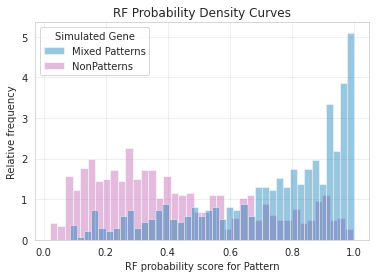

In [13]:
group = ['test','control']

test = df[(df['group']==group[0])]
control = df[(df['group']==group[1])]

print(len(control['prob_pattern'].unique()))
print(len(test['prob_pattern'].unique()))


plt.hist(control['prob_pattern'], bins=40, alpha=0.5, label='NonPatterns', density=True, color=colorblind_palette[4])
plt.hist(test['prob_pattern'], bins=40, alpha=0.4, label='Mixed Patterns', density=True, color=colorblind_palette[0])


# Get the handles and labels from the legend
handles, labels = plt.gca().get_legend_handles_labels()

# Sort them together based on the labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

# Set the legend again with the sorted handles and labels
plt.legend(handles, labels, loc='upper left', title="Simulated Gene")

plt.title("RF Probability Density Curves")
plt.xlabel("RF probability score for Pattern")
plt.ylabel("Relative frequency")
plt.show()

<ipython-input-21-250f15eba21e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pattern'] = patterns
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence

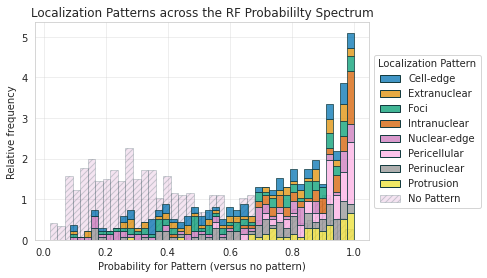

In [21]:
patterns = mixed_gene.obs['pattern'].values
test['pattern'] = patterns

palette = [colorblind_palette[0],colorblind_palette[1],colorblind_palette[2],colorblind_palette[3],colorblind_palette[4], colorblind_palette[6],colorblind_palette[7],colorblind_palette[8]]
plt.hist(control['prob_pattern'], bins=40, alpha=0.2, label='Non-patterns', density=True, color=colorblind_palette[4], hatch='////', edgecolor='#143C40')
hist_plot = sns.histplot(data=test, x='prob_pattern', hue='pattern', bins=40, multiple='stack', stat='density', palette=palette, edgecolor='#143C40')

non_patterns_patch = mpatches.Patch(facecolor=colorblind_palette[4], hatch='////', alpha=0.2, edgecolor='#143C40', label='Non-patterns')
handles, labels = hist_plot.get_legend().legendHandles, hist_plot.get_legend().get_texts()
labels = ['Cell-edge',
 'Extranuclear',
 'Foci',
 'Intranuclear',
 'Nuclear-edge',
 'Pericellular',
 'Perinuclear',
 'Protrusion'] # [label.get_text() for label in labels] -> but capitalized
plt.legend(title="Localization Pattern", handles=handles + [non_patterns_patch], labels=labels + ['No Pattern'], loc='center left', bbox_to_anchor=(1, 0.5))

plt.title("Localization Patterns across the RF Probabililty Spectrum")
plt.xlabel("Probability for Pattern (versus no pattern)")
plt.ylabel("Relative frequency")
plt.show()

# Statistics

## RF based

In [150]:
from scipy.stats import ks_2samp
import numpy as np

In [181]:
strength = 'intermediate'
count = '10-30'
sample = 50

mixed_gene = create_simulated_gene(adata_test, mixed_patterns = True, pattern_strength = strength, rna_count = count, sample_size = sample, random_seed = True)
random_gene = create_simulated_gene(adata_test, pattern = 'random', mixed_patterns = False, rna_count = count, sample_size = sample, random_seed = True)
rows = []

test = rf_pattern_balanced.predict_proba(mixed_gene.obsm["latent"])[:,1]
control = rf_pattern_balanced.predict_proba(random_gene.obsm["latent"])[:,1]
for value in test:
    rows.append({'prob_pattern': value, 'group': 'test'})
for value in control:
    rows.append({'prob_pattern': value, 'group': 'control'})
df = pd.DataFrame(rows)

In [182]:
# KS test over multiple gene_ids. 
pattern = df[(df['group']=='test')]
control = df[(df['group']=='control')]

# Perform two-sample KS test
statistic, pvalue = ks_2samp(pattern['prob_pattern'], control['prob_pattern'])
print('Test statistic:', statistic)
print('P-value:', pvalue)

Test statistic: 0.42
P-value: 0.0002460240344273171


## Latent Space based

In [ ]:
strength = 'strong'
count = '10-30'
sample = 5

pattern = create_simulated_gene(adata_test, mixed_patterns = True, pattern_strength= strength, rna_count = count, sample_size = sample, random_seed=True)
control = create_simulated_gene(adata_test, pattern = 'random', mixed_patterns = False, rna_count = count, sample_size = sample, random_seed=True)

In [ ]:
from power_analysis import latent_space_statistic

# Perform permutation test
p_value, observed_statistic, permuted_statistics = latent_space_statistic(
    pattern.obsm['latent'], 
    control.obsm['latent'], 
    n_permutations=9999, return_distances=True, for_power_purposes=False)

print(f"Observed chamfer distance: {observed_statistic}")
print(f"P-value: {p_value}")